# Predicting Pet Insurance Claims - Exploratory Data Analysis

## 1 Introduction

### 1.1 Background
Whenever a pet insurance policy holder incurs veterinary expenses related to their enrolled pet, they can submit claims for reimbursement, and the insurance company reimburses eligible expenses. To price insurance products correctly, the insurance company needs to have a good idea of the amount their policy holders are likely to claim in the future. 

### 1.2 Project Goal
The goal of this project is to create a machine learning model to predict how much (in dollars) a given policy holder will claim for during the second year of their policy. 

### 1.3 Initial Questions for EDA
Below are a few initial questions to answer and areas of interest for the detailed data analysis.
* What patterns or relationships exist between species and our other features?
* What is the distribution of our claims amounts by year? By breed? By species? By Age?
* Does enroll path matter when it comes to claims amounts?

Let's get started by importing the data we cleaned up in the data wrangling notebook.

## 2 Setup

### 2.1 Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### 2.2 Data Load & Preview

In [2]:
# Read in the data file generated during data wrangling
df = pd.read_csv('../data/merged_pets.csv')

# Preview
df.head(7).T

,0,1,2,3,4,5,6
PetId,0,1,2,3,4,5,6
Species,Dog,Dog,Dog,Dog,Dog,Dog,Cat
Breed,Schnauzer Standard,Yorkiepoo,Mixed Breed Medium,Labrador Retriever,French Bulldog,Shih Tzu,American Shorthair
Premium,84.54,50.33,74.0,57.54,60.69,43.53,47.4
Deductible,200,500,500,500,700,700,250
EnrollPath,Web,Phone,Phone,Phone,Web,Phone,Web
AgeYr1,3,0,0,0,0,2,0
YoungAge,0,0,0,0,0,0,0
MixedBreed,0,0,1,0,0,0,0
AmtClaimsYr1,0.0,0.0,640.63,0.0,7212.25,2665.67,0.0


In [3]:
df.shape

(50000, 18)

### 2.3 Data Wrangling Summary 
Before we get started on the analysis, let's take a moment to recap what we've learned so far and what the data looks like.

#### 2.3.1 What do we know? 
* **Shape** - Our clean dataframe is 50000 rows with each row corresponding to a single pet.
* **Basic Info** - For each pet, we have some basic info including species, breed, age at time of enrollment and enroll path.
* **Policy Info** - We also have policy-level info for each pet including the monthly premium and deductible amount for claims.
* **Claims Data** - We also have claims data for each pet covering the first two policy years including:
    * Number of claims per year and total (years 1 and 2 combined)
    * Average claim amount per year and total (years 1 and 2 combined) 
    * Amount of claims per year and total (years 1 and 2 combined)
* **New Columns** - Finally, we have a couple of columns we generated during data wrangling to capture specific aspects of the data. These include:
    * YoungAge - Designation for pets who enrolled at a very young age (< 7 weeks)
    * MixedBreed - Designation for pets classified as some sort of *mixed* breed

#### 2.3.2 Initial Observations
* **Species** - We have two species of pets, Cats and Dogs
* **Breed** - We have 373 unique breeds in total (55 cat and 318 dog)
* **Age** - The age range is between 0 (i.e., < 1 year) and 13
* **Premium** - Premiums fall into a wide range with a few outlier values close to \\$1000
* **Deductible** - Deductibles are fairly well distributed and appear to be stratified across a range of common values.
* **Claims** 
    * For cats and dogs, the median value for total number and total amount of claims is 0.
    * On the flip side, both species have some significant outliers in both categories (number and amount of claims)
    
Now that we have a bit more context, let's jump in to the analysis.

## 3 Data Analysis
As a first step, we'll look at our count of pets per species. With that as our jumping off point, we can start investigating the first question from the intro... What patterns or relationships exist between species and our other features?

### 3.1 What is the count of pets per species?

In [4]:
df.Species.value_counts()

Dog    41976
Cat     8024
Name: Species, dtype: int64

As observed in data wrangling, we have approximately 50,000 pets in our data, roughly 85% of which are dogs. The remaining 15% are cats, so that keeps things fairly simple as we only have two breeds to compare. 

**But why do we see such a big discrepency in the number of dogs vs. the number of cats?**

It could mean that dogs are a more popular option for a pet, or it could mean that dogs are more expensive to keep healthy and insurance is needed. Intuitively, that should mean that dog owners have higher total claims amounts or a higher number of claims than cat owners on a per pet basis. 

Let's take a look.

### 3.2 Do dogs have higher claims or more claims than cats?
Based on what we observed in data wrangling, we know there are some very significant outliers in terms of claims amounts that will affect the interpretability of our plots. Let's filter down to a smaller range and take a look at the data.

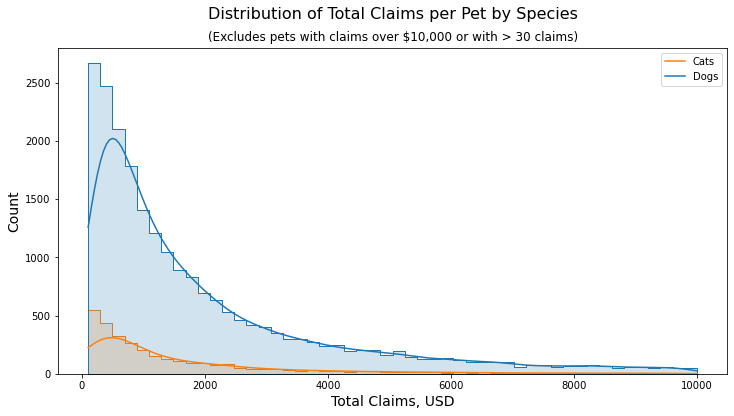

In [19]:
# Filter out outliers for number of claims and claim amounts
claim_filter = df[(df.AmtClaimsTotal < 10000) & (df.AmtClaimsTotal > 100) &
                 (df.NumClaimsTotal < 30) & (df.NumClaimsTotal > 0)]

# Create a histogram showing total claims by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x="AmtClaimsTotal", data=claim_filter, hue='Species', alpha=0.2,
             element='step', kde=True, bins=50)

# Plot titles, labels, legend and display
plt.title("Distribution of Total Claims per Pet by Species", y=1.07, fontsize=16)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.92, x=0.513, fontsize=12)
plt.xlabel("Total Claims, USD", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(labels=(['Cats', 'Dogs']), loc='upper right')
plt.savefig('../figures/Total-Claims-by-Species.png')
plt.show()

The distributions for claims amounts per pet look somewhat similar, both spike on the low end and have long tails to the right. It does appear that the distribution for dogs is shifted somewhat further to the right overall but difficult to tell in this view.

Let's see if the number of claims is any different.

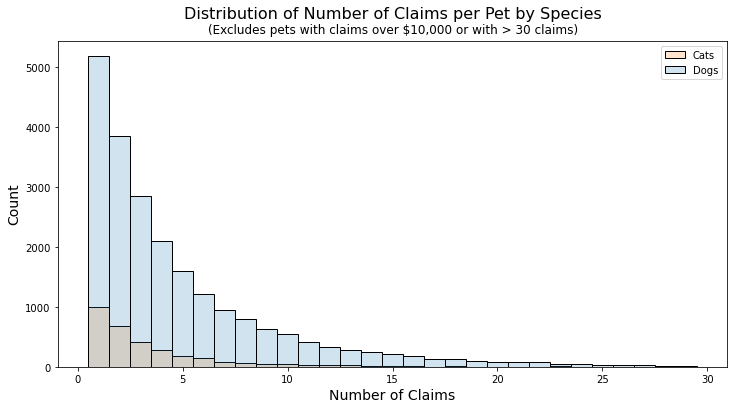

In [28]:
# Create a histogram showing number of claims per pet by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x="NumClaimsTotal", data=claim_filter, hue='Species', alpha=0.2,
             element='bars', bins=30, discrete=True)

# Plot legend and display
plt.title("Distribution of Number of Claims per Pet by Species", y=1.05, fontsize=16)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.92, x=0.513, fontsize=12)
plt.xlabel("Number of Claims", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(labels=(['Cats', 'Dogs']), loc='upper right')
plt.show()

Again, there doesn't seem to be an obvious story in the plot above and it's hard to see much difference in species when it comes to claims. Let's look at a scatterplot of the data to see if that shows anything interesting.

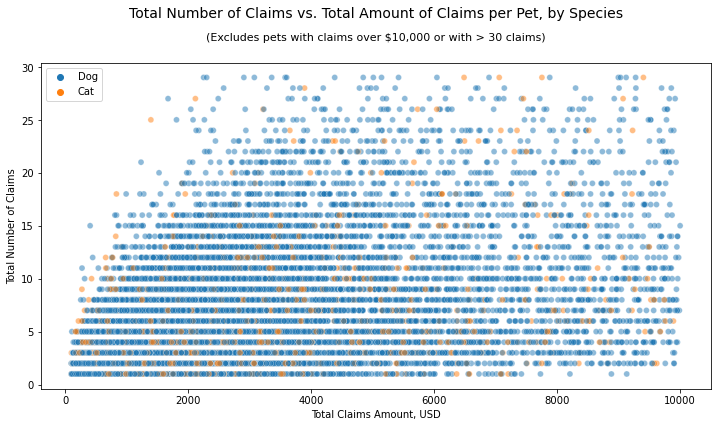

In [21]:
# Create a scatterplot showing Number of Claims vs Amount of Claims per pet by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=claim_filter, hue="Species", 
                alpha=0.5).set(title="",
                               xlabel="Total Claims Amount, USD", ylabel="Total Number of Claims")

# Plot legend, add title, and display
plt.title("Total Number of Claims vs. Total Amount of Claims per Pet, by Species", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.95, x=0.513, fontsize=11)
plt.legend(loc='upper left')
plt.show()

The scatterplot is still inconclusive when grouping the species together. Let's try separating Cats and Dogs and adding a regression line to the data as a next step.

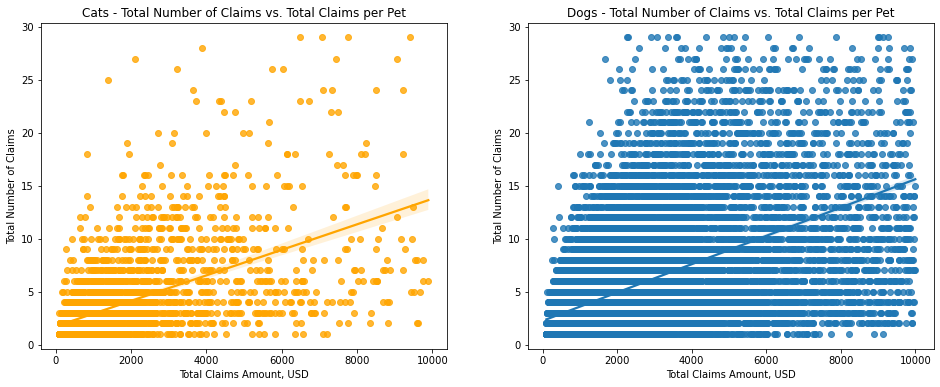

In [22]:
# Create regplots showing number of claims vs total claims amount by species
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.regplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=claim_filter[claim_filter.Species == 'Cat'],  
                ax=ax1, color="Orange"
                ).set(title="Cats - Total Number of Claims vs. Total Claims per Pet",
                     xlabel="Total Claims Amount, USD", ylabel="Total Number of Claims")
sns.regplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=claim_filter[claim_filter.Species == 'Dog'],  
                ax=ax2).set(title="Dogs - Total Number of Claims vs. Total Claims per Pet", 
                            xlabel="Total Claims Amount, USD", ylabel="Total Number of Claims")

plt.show()

Interesting! We still don't see much difference in species when it comes to total amount of claims or total number of claims per pet. Based on this alone, we could make a case that dropping species from the data makes sense. But before we take such a drastic step, let's complete analysis on some of the other features. 

**Conclusion**

* Dogs may have slightly higher total claims than cats, but the patterns between species are strikingly similar
* Initial observations are that species isn't much of a factor in predicting claims amounts

### 3.3 Do dogs cost more to insure?

So our initial hypothesis - that dogs have higher claims amounts or more claims than cats - does not appear to be the case (at least not in a significant way). Based on this, we would expect to see similar premiums and deductibles across our species, but can we see that in the data?

In data wrangling, we observed some pets with very high premiums that will undoubtedly skew our analysis. Let's start by filtering down to a smaller range and then take a look at our distributions.

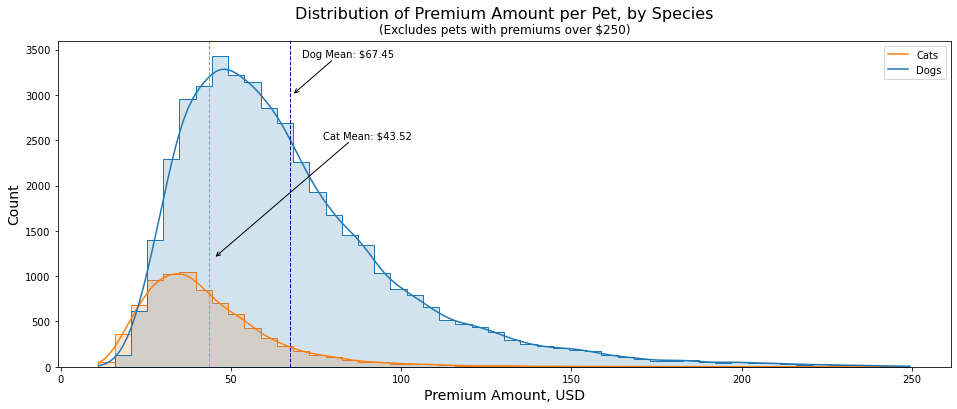

In [24]:
# Filter out the outlier premiums
prem_filter = df[df.Premium < 250][['Premium', 'Deductible', 'Species', 'AgeYr1']]
dog_mean = prem_filter[prem_filter.Species == 'Dog']['Premium'].mean()
cat_mean = prem_filter[prem_filter.Species == 'Cat']['Premium'].mean()

# Create a histogram showing premium amounts by species
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.histplot(x="Premium", data=prem_filter, hue="Species", alpha=0.2,
             element='step', bins=50, kde=True)

# Plot mean premium amount for dogs and cats
plt.axvline(cat_mean, color='darkorange', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(cat_mean*1.77, max_ylim*0.7, 'Cat Mean: ${:.2f}'.format(cat_mean))
ax.annotate("", xy=(45, 1200), xytext=(85, 2490), arrowprops=dict(arrowstyle="->"))

plt.axvline(dog_mean, color='darkblue', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(dog_mean*1.05, max_ylim*0.95, 'Dog Mean: ${:.2f}'.format(dog_mean))
ax.annotate("", xy=(68, 3000), xytext=(80, 3390), arrowprops=dict(arrowstyle="->"))

# Add title and display plot
plt.title("Distribution of Premium Amount per Pet, by Species", y=1.05, fontsize=16)
plt.suptitle("(Excludes pets with premiums over $250)", y=0.92, x=0.513, fontsize=12)
plt.xlabel("Premium Amount, USD", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(labels=(['Cats', 'Dogs']), loc='upper right')
plt.savefig('../figures/Premium-by-Species.png')
plt.show()

Once again, looking at the premium distribution curves we see similar trends for both species but with dogs shifted further to the right. By adding the mean premium values, it's clear that dog owners do pay higher premiums *on average* when compared to cats. 

How does this trend affect deductible amounts? If dog owners pay higher premiums, then potentially they should have lower deductibles. Rather than plotting a distribution, let's look at a scatterplot of Premium vs. Deductible to see if any noticeable trends stand out.

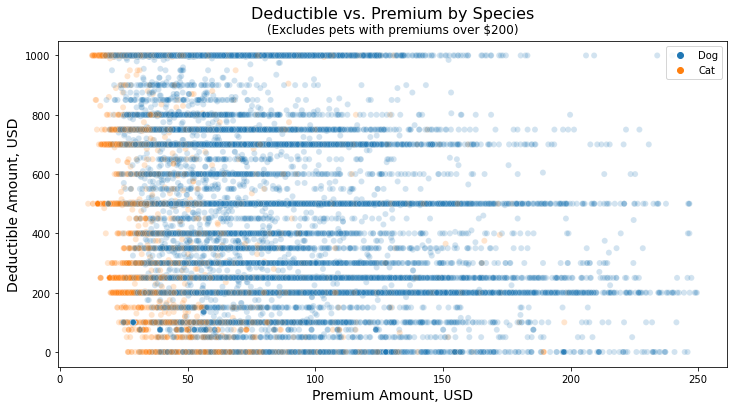

In [26]:
# Create a scatterplot showing deductible vs premium amounts by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(y="Deductible", x="Premium", data=prem_filter, hue="Species", 
                alpha=0.2)

# Add title and display plot
plt.title("Deductible vs. Premium by Species", y=1.05, fontsize=16)
plt.suptitle("(Excludes pets with premiums over $200)", y=0.92, x=0.513, fontsize=12)
plt.xlabel("Premium Amount, USD", fontsize=14)
plt.ylabel("Deductible Amount, USD", fontsize=14)
plt.legend(loc='upper right')
plt.show()

In [11]:
# Display the mean deductible per species
dog_mean = df[df.Species == 'Dog']['Deductible'].mean()
cat_mean = df[df.Species == 'Cat']['Deductible'].mean()
print("Mean Deductible Amounts by Species (full dataset)")
print('Cat Mean Deductible: ${:.2f}'.format(cat_mean))
print('Dog Mean Deductible: ${:.2f}'.format(dog_mean))

Mean Deductible Amounts by Species (full dataset)
Cat Mean Deductible: $433.97
Dog Mean Deductible: $506.69


For deductible, we see a similar striation of the data for both dogs and cats at round number values (250, 500, 750), but it seems clear that cats tend to be bunched on the low end of the spectrum across the range. This trend is confirmed by looking at the mean values for our unfiltered dataframe where we see that dogs do have higher deductibles by ~\\$75 on average. So we are starting to see a picture here that *generally*, dogs are more expensive than cats (at least when it comes to insurance payments). 

**Conclusions**

* Dogs and cats both have a broad range of premiums and deductibles with similar distributions for each 
* On average, dogs have higher premiums and higher deductibles than cats

### 3.4 How many pets have claims in one or both years?
So far in EDA, we've seen that there isn't much of a difference in the distributions of the total number of claims across species. We've also observed both in EDA and data wrangling, that a significant number of pets have no claims at all within the first two years. 

**But what trends do we see for pets with claims in one or both years?** 
* Do the majority have claims in both years or only one year? 
* Additionally, are there any patterns that jump out when we look at pets with claims in both years in terms of species or age?

First, let's create a basic function to determine for each pet, if they have no claims, claims in one year (either year 1 or year 2), or claims in both years. Then we can plot our results to see if anything interesting jumps out.

In [12]:
# Create function to populate new column as count of number of years with claims (0, 1, 2)
def claim_yrs(row):
    if (row["NumClaimsTotal"] == 0):
        return 0
    elif ((row["NumClaimsYr1"] > 0) & (row["NumClaimsYr2"] > 0)):
        return 2
    else:
        return 1

# Apply function to df to create new column
df["YrsWithClaims"] = df.apply(claim_yrs, axis=1)

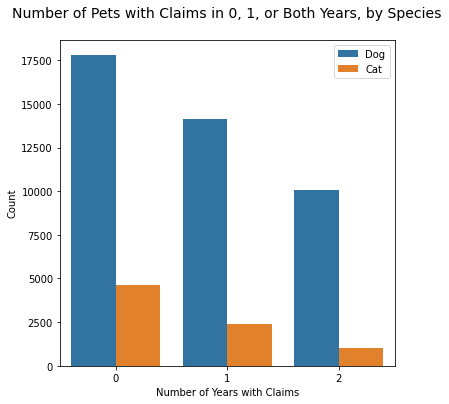

In [13]:
# Plot the count of pets with claims in 0, 1 or both years
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.countplot(x='YrsWithClaims', data=df, hue="Species").set(ylabel="Count",
                                                             xlabel="Number of Years with Claims")

# Add title and display plot
plt.title("Number of Pets with Claims in 0, 1, or Both Years, by Species", y=1.05, fontsize=14)
# plt.suptitle("(Excludes pets with premiums over $200)", y=0.95, x=0.513, fontsize=11)
plt.legend(loc='upper right')
plt.show()

As noted earlier, the majority of pets in our data (and for each species) have no claims at all in the two years included in the dataset. And again, we see similar looking trends between species in terms of the counts at 0, 1 and 2 years, but it's hard to make out any differences since the dataset is unbalanced toward dogs by nearly 6 to 1. 

Let's see if plotting this based on the percentage of each species with claims in 0, 1 or 2 years highlights any differences. 

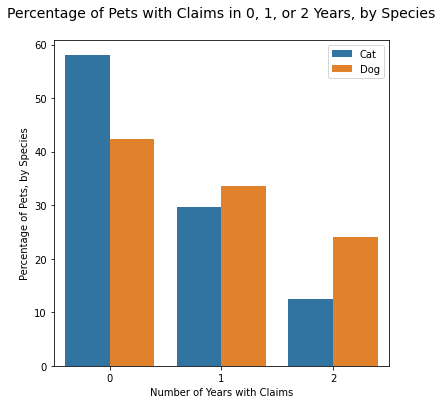

In [14]:
# Calculate the percentage of each species with claims in 0,1, or 2 years
claim_yr_counts = (df.groupby(['Species'])['YrsWithClaims']
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('YrsWithClaims'))

# Plot the data 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.barplot(x="YrsWithClaims", y="Percentage", hue="Species", data=claim_yr_counts 
           ).set(xlabel="Number of Years with Claims", ylabel="Percentage of Pets, by Species")

# Plot the legend and display
plt.title("Percentage of Pets with Claims in 0, 1, or 2 Years, by Species", y=1.05, fontsize=14)
plt.legend(loc='upper right')
plt.show()

Interesting! By plotting the percentages of each species with claims in zero, one, or both years, we see a somewhat unexpected result. Dogs are less likely to have claims overall and cats are more likely to have claims in one or both policy years. In fact, cats are almost twice as likely to have claims in both policy years than are dogs. If we had data beyond two years, it would be interesting to see if this holds for longer time periods. For now, we'll have to leave that to speculation.

However, this is adds more support to the idea that there are some differences in species and it's likely not something we want to drop. We may want to revisit the data on number of years with claims later as we get into breed analysis. For now, we can draw a couple of basic conclusions and move on.

**Conclusions**
* Around one half of pets in both species have no claims at all
* Based on percentages of each species, cats are more likely to have claims in one or both years.

### 3.5 Do insurance claims rise with age?
On the surface, this feels like the most obvious question in the world and maybe we should just answer "Yes" and move on with our lives. But then again, it's probably worth a look to see if our intuition holds.

To start with, let's take a very basic, high level look at average total claims per pet by age. No species breakdown yet, let's just try and discern whether age matters at all when it comes to claims amounts.

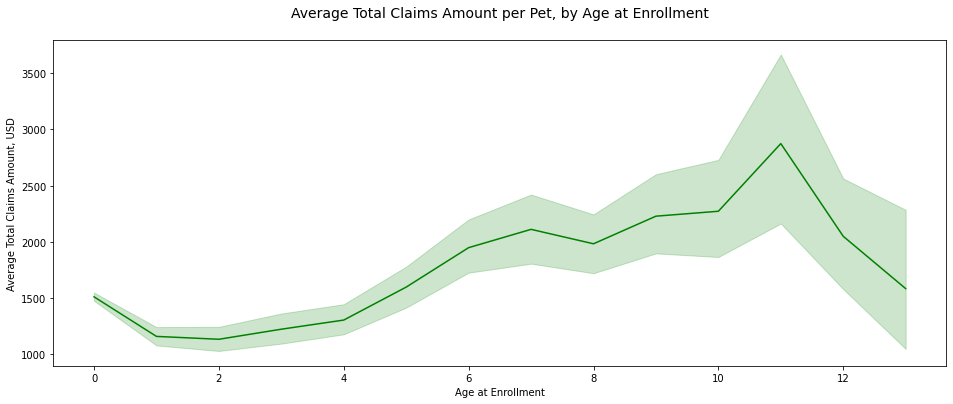

In [15]:
# Create a line plot showing total claims by Age
f, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.lineplot(x="AgeYr1", y="AmtClaimsTotal", data=df,
             color="Green", ci=95).set(xlabel="Age at Enrollment", ylabel="Average Total Claims Amount, USD")

# Add titles and display
plt.title("Average Total Claims Amount per Pet, by Age at Enrollment", y=1.05, fontsize=14)
# plt.suptitle("(Unfiltered Dataset)", y=0.95, x=0.513, fontsize=11)
plt.show()

The line plot confirms our intuition - that total claims amounts tend to rise with age. We can also see that the confidence interval expands with age as well, indicating an increase in variability as pets age. This also makes sense as we would expect that some pets stay relatively healthy in old age and some accumulate health issues.

An interesting observation in the plot above is that the rising claims average peaks around age 11 and then starts moving back down again. It's hard to say what that's about although it could have something to do with the different life expectancies for pet breeds.

Next, let's look at the distribution of total claims by age using a violin plot.

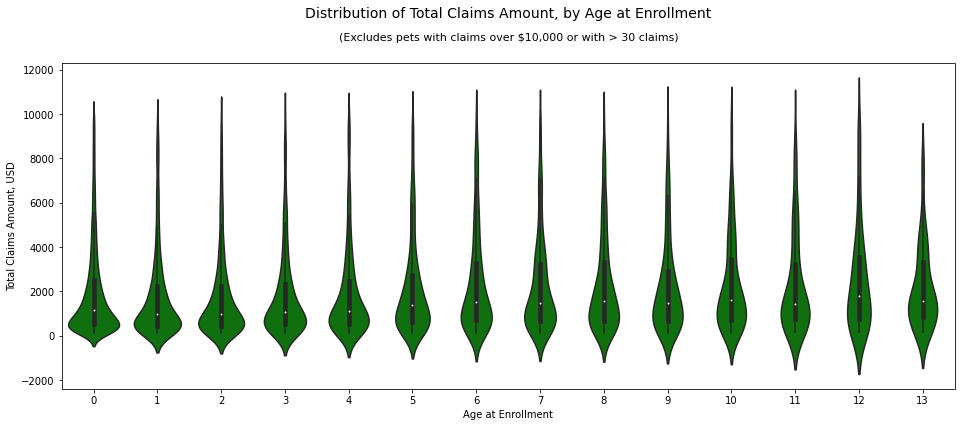

In [16]:
# Create a violin plot showing distribution of total claims based on year of enrollment
f, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.violinplot(x="AgeYr1", y="AmtClaimsTotal", data=claim_filter,
               color="Green").set(xlabel="Age at Enrollment", ylabel="Total Claims Amount, USD")

# Add titles and display
plt.title("Distribution of Total Claims Amount, by Age at Enrollment", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.95, x=0.513, fontsize=11)
plt.show()

At a high level, the violin plot shows the distribution of total claims amounts changing with age. As age increases, we see the spread of total claims amounts increasing as well. That said, the details of the distribution are difficult to make out in this view and it's tough to know if there is anything significant going on or not.

Let's take a look at the cumulative distributions by age and species and see if that provides a clearer picture.

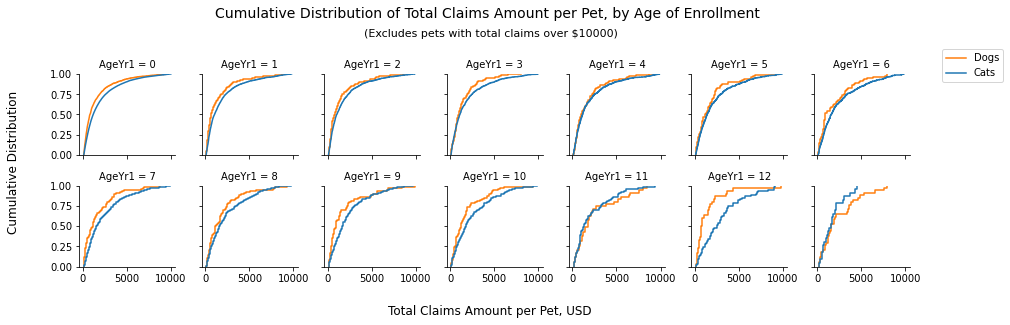

In [17]:
# Plot the ecdf of total claims by pet age at enrollment
g = sns.displot(claim_filter, x="AmtClaimsTotal", col="AgeYr1", col_wrap=7, hue="Species",
                kind="ecdf", height=1.8, legend=False) 
g.set_axis_labels("", "");

# Add titles, legend and display
plt.title("Cumulative Distribution of Total Claims Amount per Pet, by Age of Enrollment",
          y=3, x=-3.4, fontsize=14)
plt.suptitle("(Excludes pets with total claims over $10000)", y=1.08, x=0.513, fontsize=11)
g.fig.legend(labels=['Dogs', 'Cats'], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.gcf().text(0.4, -0.025, 'Total Claims Amount per Pet, USD', fontsize=12)
plt.gcf().text(-0.02, 0.3, 'Cumulative Distribution', fontsize=12, rotation=90)
plt.show()

Looking at the cumulative distributions, we see similar trends at every age. This view also supports the earlier observation that variability tends to increase with age.

In terms of species differences, we can see that at just about every age, dogs *tend* to have higher claims amounts, although the differences are very slight in most cases. At the oldest band of of ages - 11, 12, and 13 - the curves start to become more erratic, likely due to the fact that the number of pets in our data is very low in that range.

We have one more age-related feature we should explore before drawing final conclusions about age in general. When we encoded the age category as an integer value, we also added a column as a designation of pets that were very young at the time of enrollment (0-7 years old). Let's take a deeper look at this in the context of total claims to see if we find anything interesting.

First, let's get a feel for the value counts for the feature.

In [18]:
df.YoungAge.value_counts()

0    49637
1      363
Name: YoungAge, dtype: int64

So the number of young pets is quite small in comparison to the number of pets overall and likely too small to matter much. Let's see if this feature tells us much about number of claims or total claims. 

In [19]:
df.groupby('YoungAge').agg({'NumClaimsYr1': ['mean', 'median'], 'NumClaimsYr2': ['mean', 'median'],
                            'AmtClaimsYr1': ['mean', 'median'], 'AmtClaimsYr2': ['mean', 'median']})

NumClaimsYr1        NumClaimsYr2        AmtClaimsYr1         \
                 mean median         mean median         mean median   
YoungAge                                                               
0            1.655438      0     1.436066      0   795.439347    0.0   
1            2.184573      0     1.771350      0  1079.955785    0.0   

         AmtClaimsYr2         
                 mean median  
YoungAge                      
0          691.845614    0.0  
1          700.938733    0.0

Just looking at the mean and median values for number of claims and total claims, we see that YoungAge does play a factor in terms of claims in year 1 with younger pets having slightly elevated claims numbers. This difference all but disappears in year 2, expecially when comparing the total claims amount (which is our target for prediction).

These numbers could be skewed by the fact that we are comparing very young pets to the entire age range of our other pets. What if we only compare pets who were very young at enrollment with pets who we classified as 0 at age of enrollment (older than 7 weeks, but less than 1 year)?

In [20]:
df[df.AgeYr1 == 0].groupby('YoungAge').agg({'NumClaimsYr1': ['mean', 'median'],
                                            'NumClaimsYr2': ['mean', 'median'],
                                            'AmtClaimsYr1': ['mean', 'median'],
                                            'AmtClaimsYr2': ['mean', 'median']})

NumClaimsYr1        NumClaimsYr2        AmtClaimsYr1         \
                 mean median         mean median         mean median   
YoungAge                                                               
0            1.879968      0     1.429673      0   853.879915    0.0   
1            2.184573      0     1.771350      0  1079.955785    0.0   

         AmtClaimsYr2         
                 mean median  
YoungAge                      
0          654.465879    0.0  
1          700.938733    0.0

Interesting! In this case, the differences actually increase a bit when looking at total claims amounts in year 2. This is enough evidence that we should probably maintain this feature for use in our predictive model.

**Conclusions**
* Average total claims amounts tend to rise with age 
* The variability of total claims amounts also rises with age
* Age matters when it comes to claims amounts, but it doesn't follow a straighforward linear relationship
* Pets that were very young at the time of enrollment (7 weeks or younger) have higher claims amounts on average in years 1 and 2 than pets who were older than 7 weeks but still under a year  

Next, let's take a look at enroll path to determine if this matters at all for our analysis.

### 3.6 Does enroll path tell us anything about pet claims?
Intuitively, it's probably safe to say no. But it could be the case that enroll path tells us something about the pet owners that translates into more or fewer claims. Let's start by looking at a count of pets in each category.

In [21]:
df.EnrollPath.value_counts()

Web      25486
Phone    23525
EB         989
Name: EnrollPath, dtype: int64

It looks like we have 3 possibilities, Web, Phone and EB. It's unclear what "EB" stands for, but luckliy that is a pretty small percentage of our data. The majority of pets were enrolled by either Web or Phone.

Since claims amounts are the focus of this project, let's see if there is any noticeable difference in the distributions of number or amount of claims related to enroll path. If not, it's probably safe for us to drop this column.

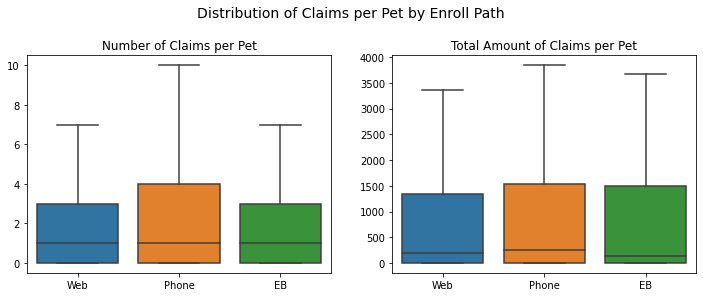

In [22]:
# Create box plots showing distribution of number and amount of claims by enroll path
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x="EnrollPath", y="NumClaimsTotal", data=df, ax=ax1,
            sym="").set(title = "Number of Claims per Pet", xlabel="", ylabel="")
sns.boxplot(x="EnrollPath", y="AmtClaimsTotal", data=df, ax=ax2,
            sym="").set(title = "Total Amount of Claims per Pet", xlabel="", ylabel="")

plt.suptitle("Distribution of Claims per Pet by Enroll Path", y=1.05, fontsize=14)
plt.show()

The distributions look very similar for all enroll paths which supports our original assertion that enroll path shouldn't have any significant impact on number or amount of claims.

Before moving on, let's look at a scatterplot for each and add a regression line. 

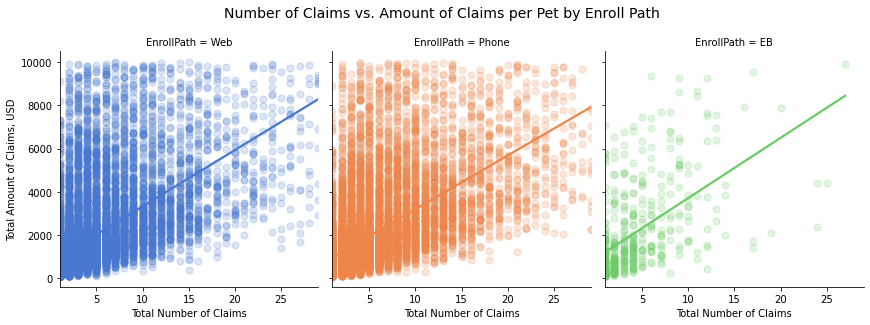

In [23]:
# Plot a regression model for each enroll path showing number of claims vs. amount of claims
g = sns.lmplot(x="NumClaimsTotal", y="AmtClaimsTotal", col="EnrollPath", hue="EnrollPath", data=claim_filter,
           ci=None, palette="muted", height=4, scatter_kws={"s": 50, "alpha": 0.2})
g.set_axis_labels("Total Number of Claims", "Total Amount of Claims, USD");

plt.suptitle("Number of Claims vs. Amount of Claims per Pet by Enroll Path", y=1.07, fontsize=14)
plt.show()

Adding the regression lines is a bit more helpful as we can see a similar trend across all three categories. For EB though, there's so little data that it's hard to trust the regression line especially as we get further out into the outliers.

While we do see some slight variation in the plots above, it doesn't seem to be significant enough to draw the conclusion that enroll path has an affect on number or amount of claims. Given this, we'll drop that column and move on.

In [24]:
# Drop EnrollPath
df = df.drop(columns=["EnrollPath"])

### 3.7 Do certain pet breeds have higher claims than others?
Again, the answer here seems like a pretty obvious "Yes", but let's see if we can prove that out in the data.

Let's start by getting a count of the number of unique breeds in each species.

In [25]:
# Get a counts of unique breeds in each species
df.groupby("Species").Breed.nunique()

Species
Cat     55
Dog    318
Name: Breed, dtype: int64

We have quite a high number of unique breeds in the data overall with dog breeds outnumbering cat breeds nearly 6 to 1 (similar to what we observed in out count of pets per breed).

To get started with our analysis, let's group our data by breed so we can get a count of pets and an average total claims amount for each breed.

In [26]:
# Group pets by breed and aggregate claims data columns
pets_by_breed = df.groupby(by=['Breed', 'Species', 'MixedBreed']).agg({'PetId': ['count'],
                                                         'AmtClaimsTotal': ['mean'],
                                                         'NumClaimsTotal': ['mean']}).reset_index()
pets_by_breed.columns = ['Breed', 'Species', 'MixedBreed', 'PetCount', 'AvgTotalClaims', 'AvgNumClaims']

# Preview
pets_by_breed.head(10)

,Breed,Species,MixedBreed,PetCount,AvgTotalClaims,AvgNumClaims
0,Abyssinian,Cat,0,24,1462.780417,4.250000
1,Affenpinscher,Dog,0,3,1746.190000,1.333333
2,Afghan Hound,Dog,0,10,645.543000,2.500000
3,Aidi,Dog,0,2,0.000000,0.000000
4,Airedale Terrier,Dog,0,41,1338.705366,2.097561
5,Akbash Dog,Dog,0,1,11383.600000,23.000000
6,Akita,Dog,0,49,1217.911020,3.591837
7,Alaskan Klee Kai,Dog,0,30,1510.666333,3.166667
8,Alaskan Malamute,Dog,0,64,3096.346719,3.765625
9,American Bandogge Mastiff,Dog,0,1,2295.070000,8.000000


#### Initial Observations
Already we see a couple of problems with breed:

1. First, it's clear there is a pretty large variance in the number of pets for each breed. Looking at the above, we see numbers ranging from 1 to 64. (And we already know from data wrangling that we have some breeds with over 3000 pets.) 

2. Second, due to this wide range, we have at least one breed with a very low count (Aidi - 1) with \$0 in total claims. Does that mean Aidi never have claims? Doubtful. On the flip side, we also see the opposite problem where certain breeds with low a low number of pets have a very high average claims amount (e.g., Akbash Dog). 

We'll need to address these issues somehow or else, we may just need to drop breed from the data. Let's continue on with the analysis to see what else we discover. We'll start by sorting the data to identify the breeds with the highest average claims amount.

In [27]:
# Sort data by average claims amount and view the top ten
pets_by_breed.sort_values("AvgTotalClaims", ascending=False).head(10)

,Breed,Species,MixedBreed,PetCount,AvgTotalClaims,AvgNumClaims
315,Selkirk Rex,Cat,0,1,25578.190000,26.000000
55,Bergamasco Sheepdog,Dog,0,1,21981.270000,50.000000
350,Tibetan Mastiff,Dog,0,2,19668.195000,9.500000
5,Akbash Dog,Dog,0,1,11383.600000,23.000000
19,American Mastiff,Dog,0,1,11064.570000,30.000000
342,St Johns Waterdog,Dog,0,1,9868.480000,16.000000
116,Colorpoint Shorthair,Cat,0,2,9806.425000,4.000000
222,Mi Ki,Dog,0,6,7556.816667,21.500000
267,Perro de Presa Canario,Dog,0,7,7225.331429,7.714286
129,Dogue de Bordeaux,Dog,0,12,6343.498333,8.500000


As suspected, we see the most expensive breed, Selkirk Rex, only includes data for one pet. And overall, the top ten is dominated by breeds with low pet counts. 

Next, let's filter the outlier breeds (average total claims > \$5000 and average number of claims > 8) and take a look at a scatter plot of average total claims vs. average number of claims in each breed. To add some interest, we can color the plot by species and size the points by the count of pets in each breed.

We'll also plot a horizontal line showing the weighted average for total claims by breed and a vertical line showing the weighted average for the number of claims per breed. This will help to smooth our outlier values a bit more and hopefully provide a better picture as to the true mean value across all breeds. 

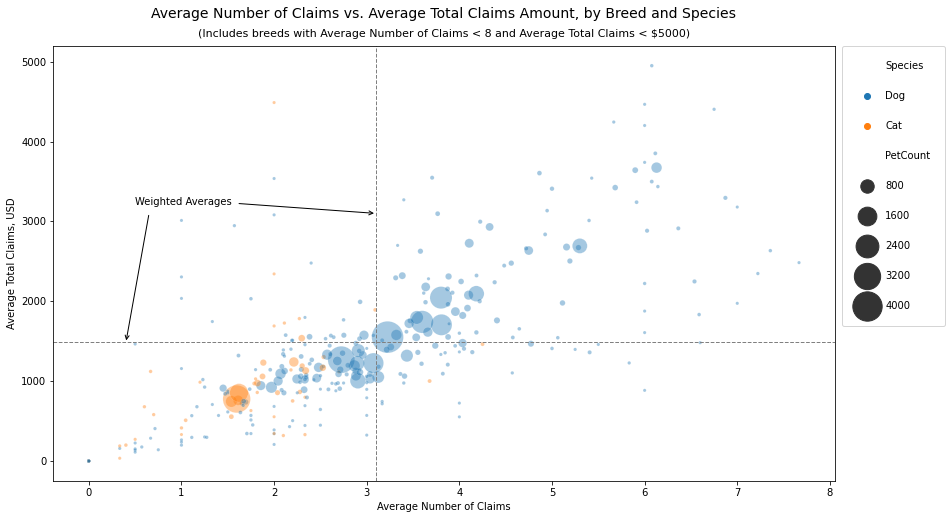

In [28]:
# Filter outliers to get a better view
filtered_pets = pets_by_breed[(pets_by_breed.AvgTotalClaims < 5000) &\
                             (pets_by_breed.AvgNumClaims < 8)]

# Create a scatterplot showing count of breed vs avg total claims
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.scatterplot(x="AvgNumClaims", y="AvgTotalClaims", data=filtered_pets, hue='Species', 
                hue_order=['Dog', 'Cat'], alpha=0.4, size="PetCount", sizes=(10, 1000))\
                .set(xlabel="Average Number of Claims", ylabel="Average Total Claims, USD")

# Calculate weighted averages for total claims and number of claims
pets_by_breed["WeightedTotalClaims"] = pets_by_breed["PetCount"] * pets_by_breed["AvgTotalClaims"]
weighted_avg_amt = pets_by_breed["WeightedTotalClaims"].sum() / pets_by_breed["PetCount"].sum()
pets_by_breed["WeightedNumClaims"] = pets_by_breed["PetCount"] * pets_by_breed["AvgNumClaims"]
weighted_avg_num = pets_by_breed["WeightedNumClaims"].sum() / pets_by_breed["PetCount"].sum()

# Plot lines showing the weighted averages for all breeds
plt.axhline(weighted_avg_amt, color='gray', linestyle='dashed', linewidth=1)
plt.axvline(weighted_avg_num, color='gray', linestyle='dashed', linewidth=1)
plt.text(0.5, 3200, "Weighted Averages")
ax.annotate("", xy=(0.4, 1485), xytext=(0.65, 3100), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(3.1, 3100), xytext=(1.6, 3225), arrowprops=dict(arrowstyle="->"))

# Add title and display plot
plt.title("Average Number of Claims vs. Average Total Claims Amount, by Breed and Species",
          y=1.05, fontsize=14)
plt.suptitle("(Includes breeds with Average Number of Claims < 8 and Average Total Claims < $5000)", 
             y=0.91, x=0.513, fontsize=11)
# plt.legend(loc='upper right', borderpad=1.5, labelspacing=2, title_fontsize='medium')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, borderpad=1.5, labelspacing=2)
plt.show()

Looking at the plot above, we see that cat breeds tend to be located in the lower left quadrant, which tells us that cats tend to have lower total claims on average than dogs. We also see a significant amount of variability for breeds with very few pets (reinforcing the initial breed observations).

**Are there any interesting trends related to Mixed Breed pets?**

In data wrangling, we added a designation to our data for pets being either from a *mixed breed* category or not. Let's look at the same plot as above but using the 'MixedBreed' designation for our hue.

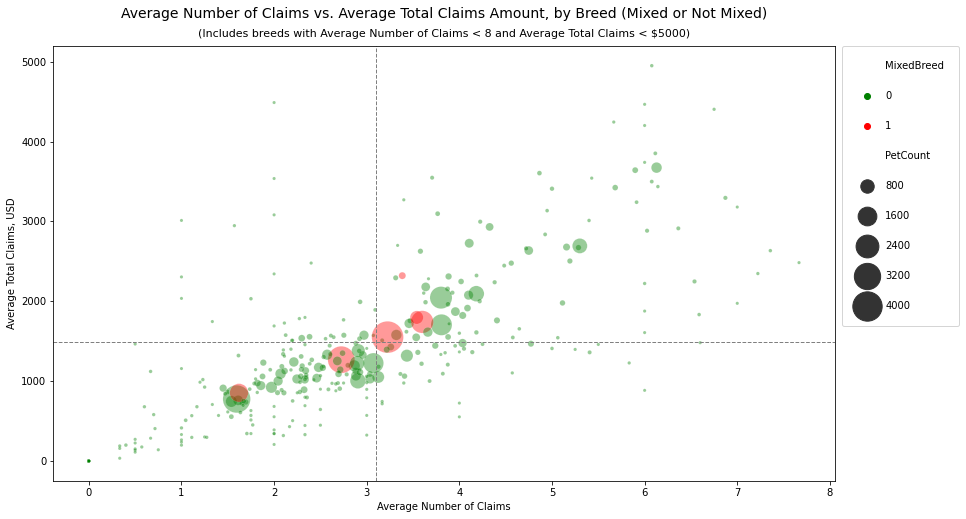

In [29]:
# Create a scatterplot showing count of breed vs avg total claims
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.scatterplot(x="AvgNumClaims", y="AvgTotalClaims", data=filtered_pets, hue='MixedBreed',
                palette=['green', 'red'], alpha=0.4, size="PetCount", sizes=(10, 1000))\
                .set(xlabel="Average Number of Claims", ylabel="Average Total Claims, USD")

# Plot lines showing the weighted averages for all breeds
plt.axhline(weighted_avg_amt, color='gray', linestyle='dashed', linewidth=1)
plt.axvline(weighted_avg_num, color='gray', linestyle='dashed', linewidth=1)

# Add title and display plot
plt.title("Average Number of Claims vs. Average Total Claims Amount, by Breed (Mixed or Not Mixed)",
          y=1.05, fontsize=14)
plt.suptitle("(Includes breeds with Average Number of Claims < 8 and Average Total Claims < $5000)", 
             y=0.91, x=0.513, fontsize=11)
# plt.legend(loc='upper right', borderpad=1.5, labelspacing=2, title_fontsize='medium')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, borderpad=1.5, labelspacing=2)
plt.show()

We see the mixed breeds showing up in red above. Not only do they tend to be on the higher end of the pet count range, they also tend to be closer to the lower left quadrant of all breeds. That said, it's not apparent that there is a significant difference between mixed and non-mixed breeds and we should be safe to drop this column form the data.

In both of the plots above we see an interesting trend line cross-cutting our weighted averages as the number of pets in a breed increases. Based on this, it does appear that breed plays a factor in claims amounts.Before moving on, let's filter out breeds with low pet counts and plot a regression model to see if the trend becomes clearer.

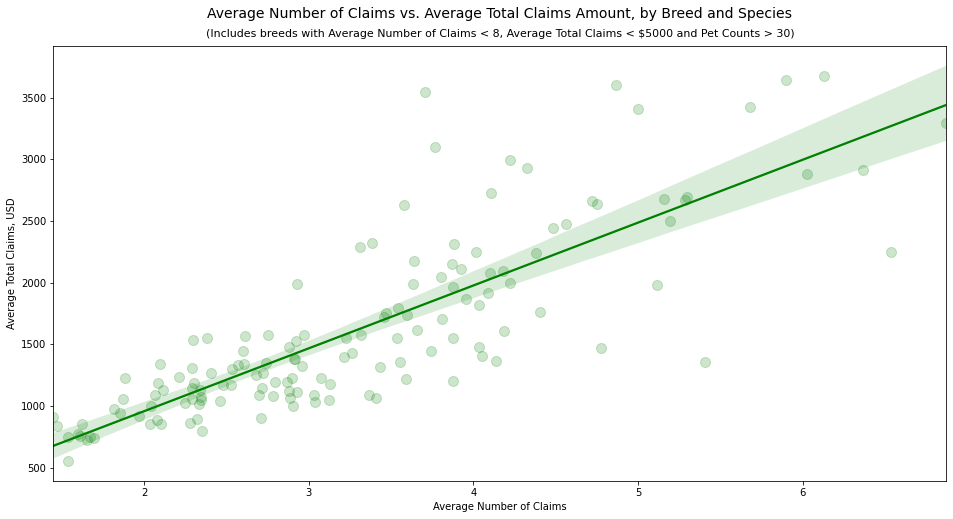

In [30]:
# Filter outlier breeds and breeds with low pet count
filtered_pets = pets_by_breed[(pets_by_breed.AvgTotalClaims < 5000) &\
                             (pets_by_breed.AvgNumClaims < 8) &\
                             (pets_by_breed.PetCount > 30)]

# Plot a regression model
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.regplot(x="AvgNumClaims", y="AvgTotalClaims", data=filtered_pets, color='g', 
            scatter_kws={"s": 100, "alpha": 0.2}).set(xlabel="Average Number of Claims", 
                                                      ylabel="Average Total Claims, USD")

# Add title and display
plt.title("Average Number of Claims vs. Average Total Claims Amount, by Breed and Species",
          y=1.05, fontsize=14)
plt.suptitle("(Includes breeds with Average Number of Claims < 8, Average Total Claims < $5000 and Pet Counts > 30)", 
             y=0.91, x=0.513, fontsize=11)
plt.show()

The plot above shows a clear trend across all breeds that as the number of claims increases, the amount of claims increases in a fairly linear fashion. We do see the variability increasing as the number of claims rises, but not by a dramatic amount.

While on the surface, this observation might seem obvious (i.e., as the number of claims goes up, so does the amount), the key takeaway here is that **breed does seem to matter** when it come to predicting claims amounts. So we know we shouldn't drop breed from the data, but we'll have to come up with some way of dealing with the large number of breed categories in preprocessing.

**Conclusions**

* As the average number of claims for a breed goes up, the average total claims amount goes up in a linear fashion
* As the number of pets in a breed increases, the variability in claims (number and amount) goes down, moving the breed closer to the linear trend line
* Breed matters when it comes to total claims amounts and we'll need to determine how to handle this categorical feature given the large number of unique values
* The *mixed breed* designation doess not appear to factor in to claims amounts and can be dropped

### 3.8 Is there any significant correlation between claims in year 2 and our other features?

So far we've observed a few trends in the data related to species, age and breed. but we haven't necessarily observed any strong connection between our features and our planned target (i.e., the amount of claims in year 2). Let's see if we can verify that finding by looking at a correlation matrix.

First we'll filter down to a subset of our features that we are likely to include in our predictive model and then we can calculate correlations and plot the result in a heatmap. For this analysis, we'll break it out by species since we have seen evidence throughout that points to differences between cats and dogs.

In [31]:
# Filter data by species
cats = df[df.Species == 'Cat']
dogs = df[df.Species == 'Dog']

# Filter species dfs down the a subset of features
cols = ['Premium', 'Deductible', 'AgeYr1', 'YoungAge', 'MixedBreed', 'AmtClaimsYr1',
             'AvgClaimsYr1', 'NumClaimsYr1', 'AmtClaimsYr2']
cats_filtered = cats[cols]
dogs_filtered = dogs[cols]

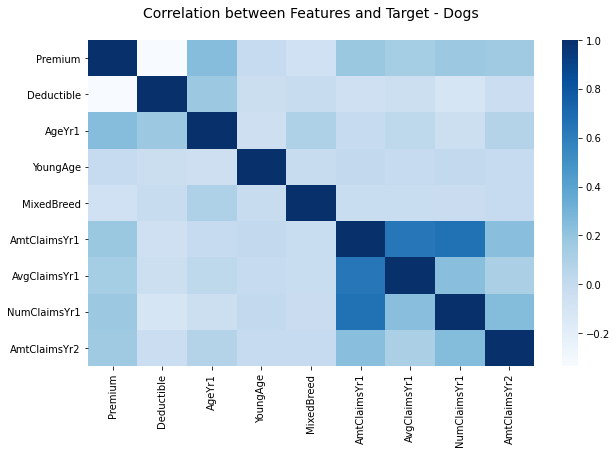

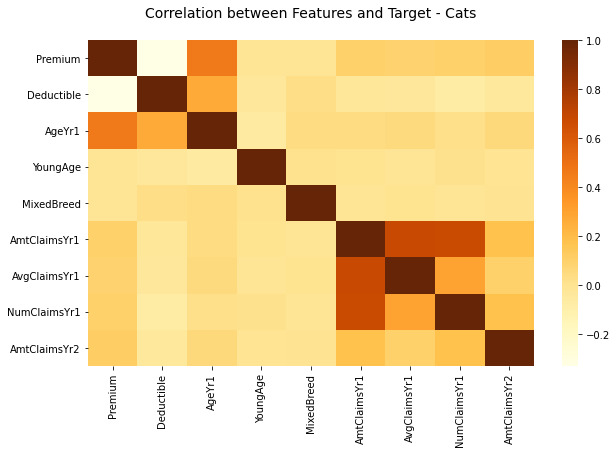

In [32]:
# Create correlation matrices
cats_corr = cats_filtered.corr()
dogs_corr = dogs_filtered.corr()

# Plot the corresponding heatmaps
plt.figure(figsize=(10,6))
_ = sns.heatmap(dogs_corr, cmap="Blues")
plt.title("Correlation between Features and Target - Dogs", y=1.05, fontsize=14)
plt.show()

plt.figure(figsize=(10,6))
_ = sns.heatmap(cats_corr, cmap="YlOrBr")
plt.title("Correlation between Features and Target - Cats", y=1.05, fontsize=14)
plt.show()

## 4 Summary and Conclusions
So what have we discovered during EDA? Let's summarize the key points.

**Species**
* Dogs and cats display similar patterns for claims, but on average, dogs tend to have more claims and higher claims totals
* Dogs and cats both have a broad range of premiums and deductibles with similar distributions for each, but *on average*, dogs have higher premiums and higher deductibles than cats
* Around one half of pets in both species have no claims at all, but cats are more likely to have claims in one or both years

**Pet Age**
* Average total claims amounts and the variability of total claims amounts tend to rise with age 
* Age matters when it comes to claims amounts, but it doesn't follow a straighforward linear relationship

**Breed**
* As the average number of claims for a breed goes up, the average total claims amount goes up in a linear fashion
* As the number of pets in a breed increases, the variability in claims (number and amount) goes down, moving the breed closer to the linear trend line
* Breed matters when it comes to total claims amounts and we'll need to determine how to handle this categorical feature given the large number of unique values

**Correlation**
* Generally, we have weak to no correlation between our features and our target variable (AmtClaimsYr2)

**Dropped Columns**
* Based on our analysis above, we decided to drop 'EnrollPath' and 'MixedBreed' from our dataframe

### 4.1 Data Cleanup and Export

In [33]:
# Drop MixedBreed
pets = df.drop(columns=["MixedBreed"])
breeds = pets_by_breed.drop(columns=["MixedBreed"])

In [34]:
# Previewing updated dataframe
pets.head().T

,0,1,2,3,4
PetId,0,1,2,3,4
Species,Dog,Dog,Dog,Dog,Dog
Breed,Schnauzer Standard,Yorkiepoo,Mixed Breed Medium,Labrador Retriever,French Bulldog
Premium,84.54,50.33,74.0,57.54,60.69
Deductible,200,500,500,500,700
AgeYr1,3,0,0,0,0
YoungAge,0,0,0,0,0
AmtClaimsYr1,0.0,0.0,640.63,0.0,7212.25
AmtClaimsYr2,1242.0,0.0,1187.68,0.0,168.75
AvgClaimsYr1,0.0,0.0,213.543333,0.0,801.361111


In [35]:
# Previewing updated dataframe
breeds.head().T

,0,1,2,3,4
Breed,Abyssinian,Affenpinscher,Afghan Hound,Aidi,Airedale Terrier
Species,Cat,Dog,Dog,Dog,Dog
PetCount,24,3,10,2,41
AvgTotalClaims,1462.780417,1746.19,645.543,0.0,1338.705366
AvgNumClaims,4.25,1.333333,2.5,0.0,2.097561
WeightedTotalClaims,35106.73,5238.57,6455.43,0.0,54886.92
WeightedNumClaims,102.0,4.0,25.0,0.0,86.0


### 4.2 Ideas for preprocessing / feature engineering

**Species** 
* Convert species to binary or split data and make predictions for cats and dogs separately

**Breed** 
* Consider raising the threshold higher to eliminate more of the unique values for breed
    * One approach could be to group breeds together as high, med, low in terms of average claims
    * Determine a minimum threshold of number of pets per breed and for any breeds under the threshold, replace the breed with 'Other'  
* Include breed summary statistics as new features; consider replacing certain pet-level 

**Premium and Deductible** 
* Consider rolling these up on a per breed basis to eliminate some variability. Since this is something set by the customer, there likely isn't much value in keeping the actual amounts per pet.

**AgeYr1** 
* Consider adding new features that factor in age (e.g., average total claims by age)

**YoungAge** 
* No changes, or decide to drop this altogether since the number of pets with this desigation is very low

**AmtClaimsYr1 and AvgClaimsYr1** 
* Keep as-is or consider rolling these up into one feature. It also might be interesting to roll these up by breed.

**NumClaimsYr1** 
* Consider dropping this column dependent on what is done with the other two claims columns for year 1 
* This could also be rolled up by Breed, or converted to a binary (claims and no-claims), although we would technically already know this provided the value for AmtClaims is greater than 0.

**Yr2 and Total columns** 
* Drop all columns except AmtClaimsYr2 (our target) as the others would not be fair to use in a predictive model for year 2

**YrsWithClaims** 
* No changes planned


### 4.3 Write New Data Files

In [36]:
# Write final dfs to csv 
pets.to_csv('../data/pets.csv')
breeds.to_csv('../data/breeds.csv')